In [1]:

import torch
import gc   
torch.cuda.empty_cache()
gc.collect()


0

In [2]:
print('dsdsdddddds')

dsdsdddddds


In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OMP_NUM_THREADS"] = "1"

# Step 2: Import necessary libraries
from typing import Optional, Dict, Any
import os
import torch
import pytorch_lightning as pl
import pandas as pd
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from rich.traceback import install
from pytorch_lightning.loggers import WandbLogger
import torch.nn as nn
import torch.optim as optim
from transformers import AutoConfig, get_cosine_schedule_with_warmup
from adapters import AutoAdapterModel, AdapterConfig
from adapters.composition import Stack
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

install(show_locals=True)

from setup import setup_src_path
print(setup_src_path())
import data.processed as processed
import config.config as config
import utils.setup as setup
import utils.functions as fn
from importlib import reload

from datasets import load_from_disk

print(config.Config.TXT_SAVE_PATH)
print(config.Config.MODEL_SAVE_PATH)

dataset = load_from_disk(f"../{config.Config.DATASETS_SAVE_PATH}/datasets")


['/home/guest/Desktop/projects/fourth-expeiments/domain_adaptation_project/union/fiction', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages', '/tmp/tmp2eev1ccz', '/home/guest/Desktop/projects/fourth-expeiments/domain_adaptation_project/modules']


2024-07-14 15:53:07.487553: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 15:53:07.669011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 15:53:08.444012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


./text-files/
./hp-model-


In [4]:
print('dsds')

dsds


In [5]:
# Step 4: Define the DomainTaskAdapter class



class DomainTaskAdapter(pl.LightningModule):
    def __init__(self, hparams):
        super(DomainTaskAdapter, self).__init__()
        self.save_hyperparameters(hparams)
        self.config = AutoConfig.from_pretrained(self.hparams["pretrained_model_name"])
        self.config.output_hidden_states = True
        self.model = AutoAdapterModel.from_pretrained(self.hparams["pretrained_model_name"], config=self.config)
        
        self.reduction_factor = self.hparams.get("reduction_factor", 16)
        if self.reduction_factor == "None":
            self.reduction_factor = 16
        self.leave_out = self.hparams.get("leave_out", [])
       
        self.saved_adapter_dir = self.hparams["saved_adapter_dir"]
        self.domain_adapter_name = self.hparams["domain_adapter_name"]
        
        adapter_config = AdapterConfig.load("seq_bn")
        
        self.task_adapter_name = self.hparams["task_adapter_name"]
        #self.model.add_adapter(self.task_adapter_name, config=adapter_config)

        self.model.load_adapter(f"{self.saved_adapter_dir}/{self.domain_adapter_name}", with_head=False)
        self.model.add_classification_head(self.task_adapter_name, num_labels=self.hparams["num_classes"])
        self.model.active_adapters = self.domain_adapter_name

        self.model.train_adapter(self.domain_adapter_name)
        print(self.model.adapter_summary())
        print(fn.print_trainable_parameters(self.model))

        self.training_outputs = []
        self.validation_outputs = []
        self.test_outputs = []
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass',                                           
                                     num_classes=self.hparams["num_classes"])
        self.f1 = torchmetrics.F1Score(task='multiclass',num_classes=self.hparams["num_classes"], average="weighted")
        self.f1_macro = torchmetrics.F1Score(task='multiclass',num_classes=self.hparams["num_classes"], average="macro")
        self.f1_micro = torchmetrics.F1Score(task='multiclass',num_classes=self.hparams["num_classes"], average="micro")
        self.softmax = nn.Softmax(dim=1)
        self.entropy_values = []  # For entropy minimization
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits,outputs.hidden_states[-1]

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask = batch["source_input_ids"], batch["source_attention_mask"]
        labels = batch["label_source"]
        logits,_ = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = self.criterion(logits, labels)
        accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        # self.training_outputs.append({
        #     "train_loss": loss,
        #     "train_accuracy":accuracy,
        #     "train_f1":f1,
        #     })
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)
        self.log("train_f1", f1)
        
        return loss
   
    def validation_step(self, batch, batch_idx):
        """validation step of DomainTaskAdapter"""
        # get the input ids and attention mask for source data
        input_ids, attention_mask = batch["source_input_ids"], batch["source_attention_mask"]
        logits,features = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_source"]
        source_loss = self.criterion(logits, labels)
        source_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))


        # get the input ids and attention mask for target data
        input_ids, attention_mask = batch["target_input_ids"], batch["target_attention_mask"]
        logits ,target_features = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_target"]
        target_loss = self.criterion(logits, labels)
        target_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        # # Entropy minimization - calculate and log entropy
        # probs = self.softmax(logits).cpu().numpy()
        # entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)
        # avg_entropy = np.mean(entropy)
        # self.entropy_values.append(avg_entropy)
     
        # this will log the mean div value across epoch
        self.log(name="source_val/loss", value=source_loss, prog_bar=True, logger=True)
        self.log(name="source_val/accuracy", value=source_accuracy, prog_bar=True, logger=True)
        self.log(name="source_val/f1", value=source_f1, prog_bar=True, logger=True)
        self.log(name="target_val/loss", value=target_loss, prog_bar=True, logger=True)
        self.log(name="target_val/accuracy", value=target_accuracy, prog_bar=True, logger=True)
        self.log(name="target_val/f1", value=target_f1, prog_bar=True, logger=True)
        
        self.validation_outputs.append({
            "source_val/loss": source_loss,
            "source_val/accuracy": source_accuracy,
            "source_val/f1": source_f1,
            "target_val/loss": target_loss,
            "target_val/accuracy": target_accuracy,
            "target_val/f1": target_f1,
            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
                })
        return {
            "source_val/loss": source_loss,
            "source_val/accuracy": source_accuracy,
            "source_val/f1": source_f1,
            "target_val/loss": target_loss,
            "target_val/accuracy": target_accuracy,
            "target_val/f1": target_f1,
            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
                            }
    def on_validation_epoch_start(self):
        self.validation_outputs = []
    
    def on_validation_epoch_end(self):
        try:
            outputs= self.validation_outputs
            mean_source_loss = torch.stack([x["source_val/loss"] for x in outputs]).mean()
            mean_source_accuracy = torch.stack([x["source_val/accuracy"] for x in outputs]).mean()
            mean_source_f1 = torch.stack([x["source_val/f1"] for x in outputs]).mean()

            mean_target_loss = torch.stack([x["target_val/loss"] for x in outputs]).mean()
            mean_target_accuracy = torch.stack([x["target_val/accuracy"] for x in outputs]).mean()
            mean_target_f1 = torch.stack([x["target_val/f1"] for x in outputs]).mean()
            print(f"target_val/loss: {mean_target_loss}")
            print(f"target_val/accuracy: {mean_target_accuracy}")
            print(f"target_val/f1: {mean_target_f1}")
            print(f"source_val/loss: {mean_source_loss}")
            print(f"source_val/accuracy: {mean_source_accuracy}")
            print(f"source_val/f1: {mean_source_f1}")

            self.log(name="source_val/loss", value=mean_source_loss, prog_bar=True, logger=True)
            self.log(name="source_val/accuracy", value=mean_source_accuracy, prog_bar=True, logger=True)
            self.log(name="target_val/loss", value=mean_target_loss, prog_bar=True, logger=True)
            self.log(name="target_val/accuracy", value=mean_target_accuracy, prog_bar=True, logger=True)
            self.log(name="target_val/f1", value=mean_target_f1, prog_bar=True, logger=True)
            self.log(name="source_val/f1", value=mean_source_f1, prog_bar=True, logger=True)
        
        
            self.log("val_loss", mean_source_loss)
            #Generate and log visualizations
            if hasattr(self.trainer, 'current_epoch'):
                self.plot_tsne(outputs, epoch=self.trainer.current_epoch, phase='validation')
                self.plot_confusion_matrix(outputs, phase='validation')
        except Exception as e:
            print(f"Error during on_validation_epoch_end: {e}")
            raise

    def test_step(self, batch, batch_idx):
        """validation step of DomainTaskAdapter"""
        # get the input ids and attention mask for source data
        input_ids, attention_mask = batch["source_input_ids"], batch["source_attention_mask"]
        logits,features  = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_source"]
        source_loss = self.criterion(logits, labels)
        source_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1_macro = self.f1_macro(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1_micro = self.f1_micro(labels, torch.argmax(self.softmax(logits), dim=1))

        # get the input ids and attention mask for target data
        input_ids, attention_mask = batch["target_input_ids"], batch["target_attention_mask"]
        logits,target_features = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_target"]
        target_loss = self.criterion(logits, labels)
        target_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1_macro = self.f1_macro(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1_micro = self.f1_micro(labels, torch.argmax(self.softmax(logits), dim=1))

       

        self.log(name="source_test/loss", value=source_loss, logger=True)
        self.log(name="source_test/accuracy", value=source_accuracy, logger=True)
        self.log(name="source_test/f1", value=source_f1, logger=True)
        self.log(name="source_test/f1_macro", value=source_f1_macro, logger=True)
        self.log(name="source_test/f1_micro", value=source_f1_micro, logger=True)
        self.log(name="target_test/loss", value=target_loss, logger=True)
        self.log(name="target_test/accuracy", value=target_accuracy, logger=True)
        self.log(name="target_test/f1", value=target_f1, logger=True)
        self.log(name="target_test/f1_macro", value=target_f1_macro, logger=True)
        self.log(name="target_test/f1_micro", value=target_f1_micro, logger=True)
        
        self.test_outputs.append({
            "source_test/loss": source_loss,
            "source_test/accuracy": source_accuracy,
            "source_test/f1": source_f1,
            "source_test/f1_macro": source_f1_macro,
            "source_test/f1_micro": source_f1_micro,
            "target_test/loss": target_loss,
            "target_test/accuracy": target_accuracy,
            "target_test/f1": target_f1,
            "target_test/f1_macro": target_f1_macro,
            "target_test/f1_micro": target_f1_micro,

            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
        })
        return {
            "source_test/loss": source_loss,
            "source_test/accuracy": source_accuracy,
            "source_test/f1": source_f1,
            "source_test/f1_macro": source_f1_macro,
            "source_test/f1_micro": source_f1_micro,

            "target_test/loss": target_loss,
            "target_test/accuracy": target_accuracy,
            "target_test/f1": target_f1,
            "target_test/f1_macro": target_f1_macro,
            "target_test/f1_micro": target_f1_micro,

            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
        }
    def on_test_epoch_start(self):
        self.test_outputs = []
    def on_test_epoch_end(self):
        try:
            outputs=  self.test_outputs
            mean_source_loss = torch.stack([x["source_test/loss"] for x in outputs]).mean()
            mean_source_accuracy = torch.stack([x["source_test/accuracy"] for x in outputs]).mean()
            mean_source_f1 = torch.stack([x["source_test/f1"] for x in outputs]).mean()
            mean_source_f1_macro = torch.stack([x["source_test/f1_macro"] for x in outputs]).mean()
            mean_source_f1_micro = torch.stack([x["source_test/f1_micro"] for x in outputs]).mean()

            mean_target_loss = torch.stack([x["target_test/loss"] for x in outputs]).mean()
            mean_target_accuracy = torch.stack([x["target_test/accuracy"] for x in outputs]).mean()
            mean_target_f1 = torch.stack([x["target_test/f1"] for x in outputs]).mean()
            mean_target_f1_macro = torch.stack([x["target_test/f1_macro"] for x in outputs]).mean()
            mean_target_f1_micro = torch.stack([x["target_test/f1_micro"] for x in outputs]).mean()

            self.log(name="source_test/loss", value=mean_source_loss)
            self.log(name="source_test/accuracy", value=mean_source_accuracy)
            self.log(name="source_test/f1", value=mean_source_f1)
            self.log(name="source_test/f1_macro", value=mean_source_f1_macro)
            self.log(name="source_test/f1_micro", value=mean_source_f1_micro)
            self.log(name="target_test/loss", value=mean_target_loss)
            self.log(name="target_test/accuracy", value=mean_target_accuracy)
            self.log(name="target_test/f1", value=mean_target_f1)
            self.log(name="target_test/f1_macro", value=mean_target_f1_macro)
            self.log(name="target_test/f1_micro", value=mean_target_f1_micro)


            # Generate and log visualizations
            if hasattr(self.trainer, 'current_epoch'):
                self.plot_tsne(outputs, epoch=self.trainer.current_epoch, phase='test')
                self.plot_confusion_matrix(outputs, phase='test')
        except Exception as e:
            print(f"Error during on_test_epoch_end: {e}")
            raise
    def save_adapter(self, location, adapter_name):
        self.model.save_adapter(location, adapter_name)
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams["learning_rate"])
        lr_scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, cooldown=0, min_lr=1e-8),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]
    def plot_tsne(self, outputs, epoch, phase):
        try:
            features = []
            labels = []
            for output in outputs:
                features.extend(output["features"].numpy())  # Use target features
                labels.extend(output["labels"].numpy())  # Use target labels

            features = np.array(features)
            labels = np.array(labels)
            print(f"Features shape: {features.shape}")
            print(f"Labels shape: {labels.shape}")

            # Flatten features if necessary
            if features.ndim > 2:
                features = features.reshape(features.shape[0], -1)
                print(f"Flattened features shape: {features.shape}")

            tsne = TSNE(n_components=2)
            tsne_results = tsne.fit_transform(features)
            plt.figure(figsize=(8, 4))
            for i in range(self.hparams["num_classes"]):
                idxs = np.where(labels == i)
                plt.scatter(tsne_results[idxs, 0], tsne_results[idxs, 1], label=f'Class {i}')
            plt.legend()
            plt.title(f't-SNE plot {phase} Epoch {epoch}')
            plt.show()  # Display the plot inline
        except Exception as e:
            print(f"Error during t-SNE plotting: {e}")
            raise

    def plot_confusion_matrix(self, outputs, phase):
        try:
            y_true = []
            y_pred = []
            for output in outputs:
                y_true.extend(output["labels"].numpy())  # Use target labels
                y_pred.extend(torch.argmax(output["logits"], dim=1).numpy())  # Use predicted labels from logits

            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            print(f"y_true shape: {y_true.shape}")
            print(f"y_pred shape: {y_pred.shape}")

            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f'Confusion Matrix {phase}')
            plt.show()  # Display the plot inline
        except Exception as e:
            print(f"Error during confusion matrix plotting: {e}")
            raise

In [6]:
# Step 5: Training and Evaluation Loop with Wandb logging
import wandb
wandb.login()
# Wandb setup and training loop
seeds = [42,10]  # List of seeds
project_name = 'ablations'  # Replace with your wandb project name
domain = 'GS'  # Replace with the specific domain for this notebook
type = 'union_macro'  # Replace with the specific type for this notebook
domain_aprev ='GS'

# Initialize results dictionary
results = {
    "last_epoch": {
        
        "source_test/loss": [],
        "source_test/accuracy": [],
        "source_test/f1": [],        
        "source_test/f1_macro": [],
        "source_test/f1_micro": [],
        "target_test/loss": [],
        "target_test/accuracy": [],
        "target_test/f1": [],
        "target_test/f1_macro": [],
        "target_test/f1_micro": [],
    },
    "best_model": {
        
        "source_test/loss": [],
        "source_test/accuracy": [],
        "source_test/f1": [],        
        "source_test/f1_macro": [],
        "source_test/f1_micro": [],
        "target_test/loss": [],
        "target_test/accuracy": [],
        "target_test/f1": [],
        "target_test/f1_macro": [],
        "target_test/f1_micro": [],
    },
    "epoch_saved": {
        
        "source_test/loss": [],
        "source_test/accuracy": [],
        "source_test/f1": [],        
        "source_test/f1_macro": [],
        "source_test/f1_micro": [],
        "target_test/loss": [],
        "target_test/accuracy": [],
        "target_test/f1": [],
        "target_test/f1_macro": [],
        "target_test/f1_micro": [],
    }
}

best_val_loss = float('inf')
best_model = None
best_model_path = ""


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Seed set to 42
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prinssst: government
print: slate
print: 69575
prinssst: government
print: slate
print: 69575


wandb: Network error (ReadTimeout), entering retry loop.


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configu

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_S              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | BertAdapterModel   | 118 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
3 | f1        | MulticlassF1Score  | 0     
4 | f1_macro  | MulticlassF1Score  | 0     
5 | f1_micro  | MulticlassF1Score  | 0     
6 | softmax   | Softmax            | 0     
-------------------------------------------------
8.9 M     Trainable params
109 M     Non-trainable params
118 M     Total params
473.522   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 1.0979019403457642
target_val/accuracy: 0.40625
target_val/f1: 0.4955030679702759
source_val/loss: 1.1056761741638184
source_val/accuracy: 0.328125
source_val/f1: 0.39756476879119873
Features shape: (64, 128, 768)
Labels shape: (64,)
Flattened features shape: (64, 98304)


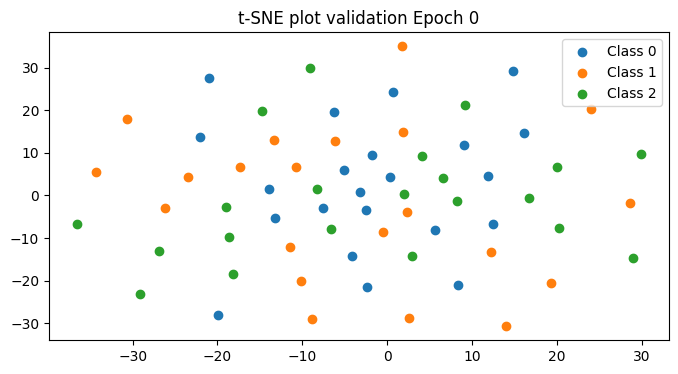

y_true shape: (64,)
y_pred shape: (64,)


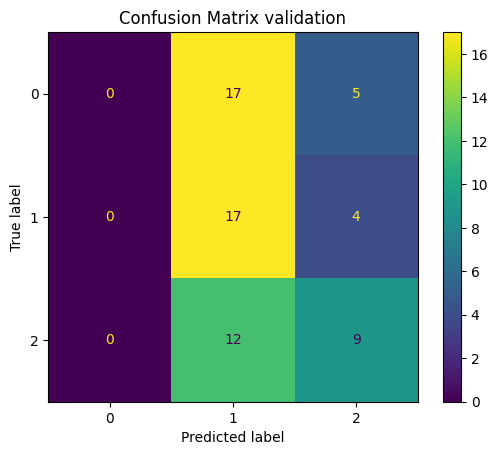

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6802766919136047
target_val/accuracy: 0.7163712382316589
target_val/f1: 0.7162084579467773
source_val/loss: 0.504758894443512
source_val/accuracy: 0.8016868233680725
source_val/f1: 0.801103413105011
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


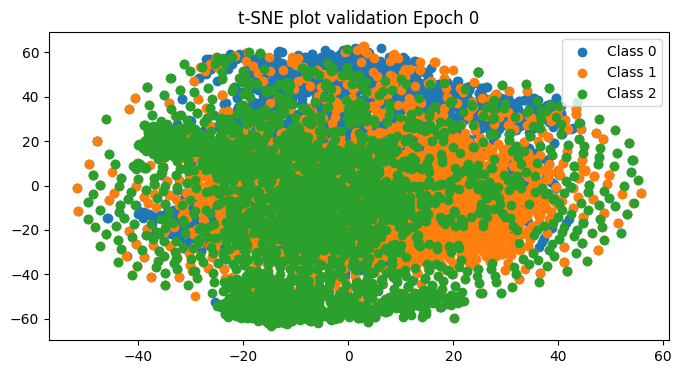

y_true shape: (7731,)
y_pred shape: (7731,)


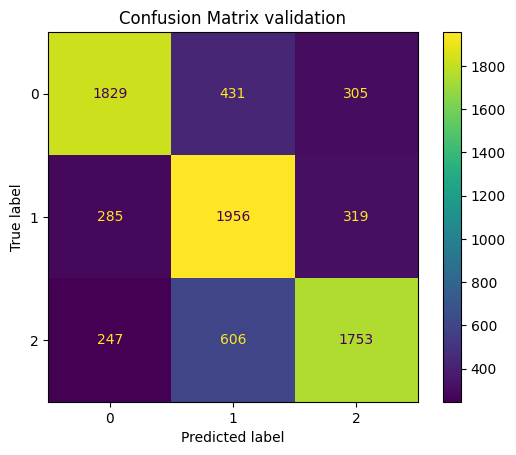

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6684474945068359
target_val/accuracy: 0.726525068283081
target_val/f1: 0.7259992957115173
source_val/loss: 0.4842042624950409
source_val/accuracy: 0.8191196918487549
source_val/f1: 0.8185887336730957
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


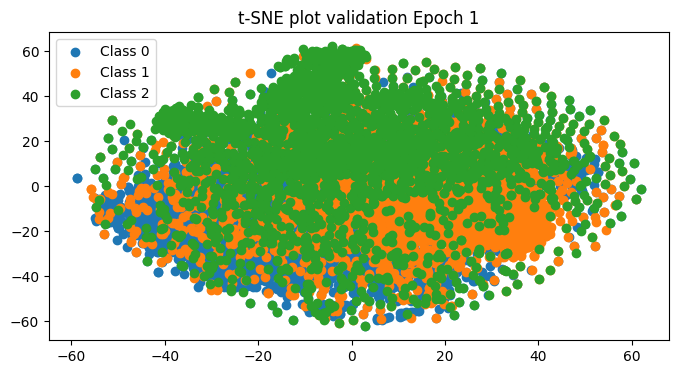

y_true shape: (7731,)
y_pred shape: (7731,)


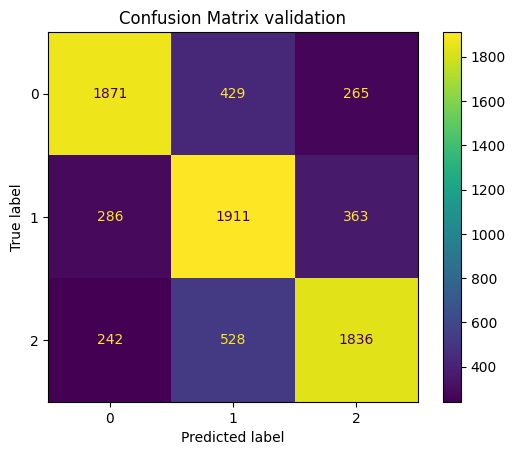

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6849915981292725
target_val/accuracy: 0.7413344979286194
target_val/f1: 0.7408913373947144
source_val/loss: 0.48804301023483276
source_val/accuracy: 0.8271666765213013
source_val/f1: 0.8267521858215332
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


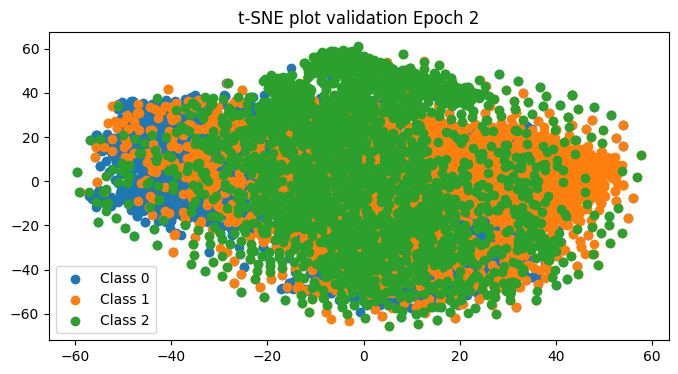

y_true shape: (7731,)
y_pred shape: (7731,)


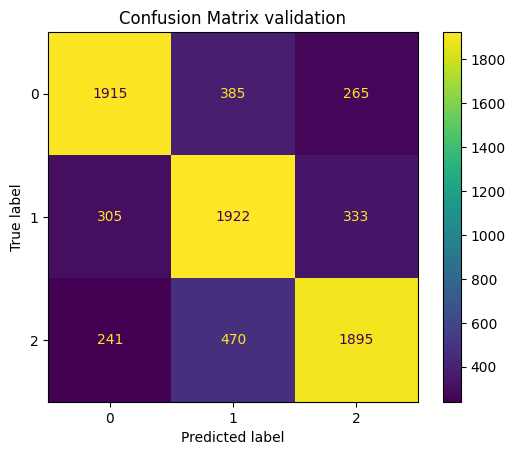

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.7252370715141296
target_val/accuracy: 0.7400431632995605
target_val/f1: 0.739813506603241
source_val/loss: 0.5178813934326172
source_val/accuracy: 0.8224771618843079
source_val/f1: 0.8226770162582397
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


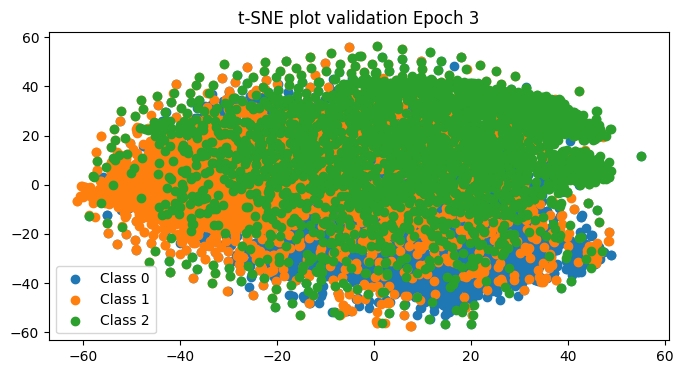

y_true shape: (7731,)
y_pred shape: (7731,)


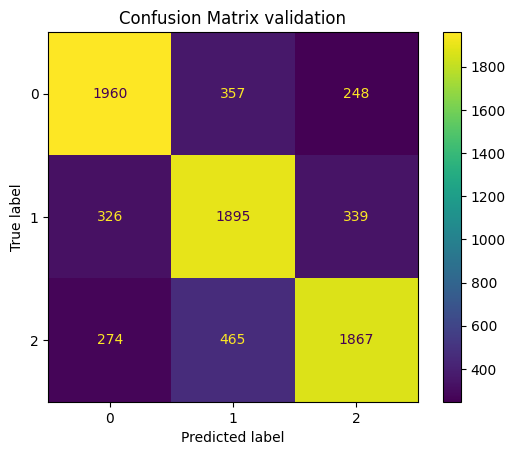

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.791297972202301
target_val/accuracy: 0.7368148565292358
target_val/f1: 0.7370925545692444
source_val/loss: 0.5577775835990906
source_val/accuracy: 0.8213557600975037
source_val/f1: 0.8213075399398804
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


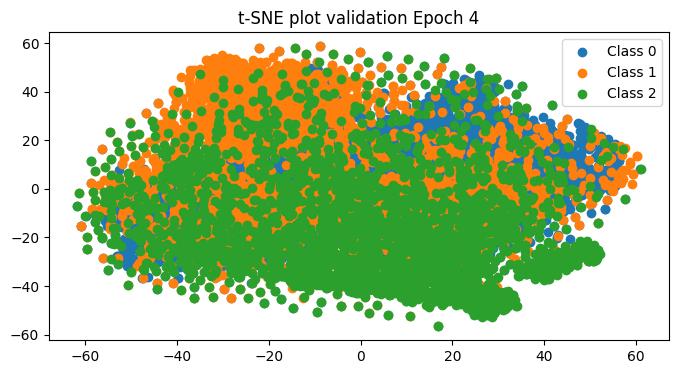

y_true shape: (7731,)
y_pred shape: (7731,)


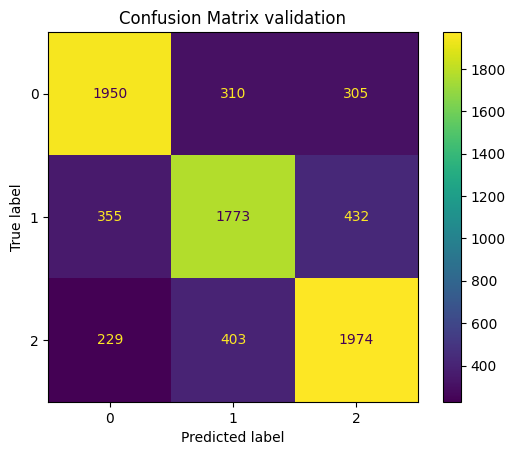

`Trainer.fit` stopped: `max_epochs=5` reached.


Best checkpoint path: checkpoints/lightning_logs/version_12/checkpoints/task-GS-epoch=01-val_loss=0.48.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_12/checkpoints/GS-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


prinssst: government
print: slate
print: 69575


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1945, 128, 768)
Labels shape: (1945,)
Flattened features shape: (1945, 98304)


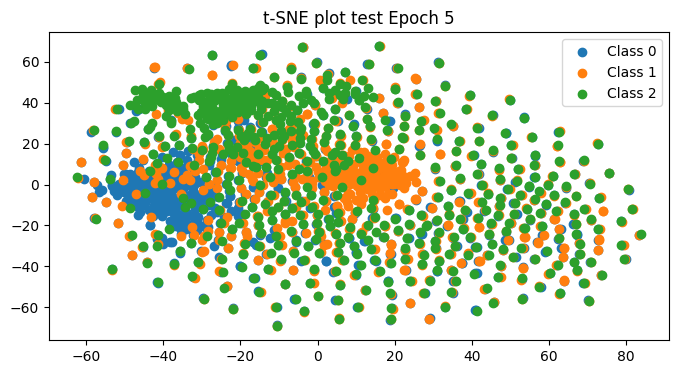

y_true shape: (1945,)
y_pred shape: (1945,)


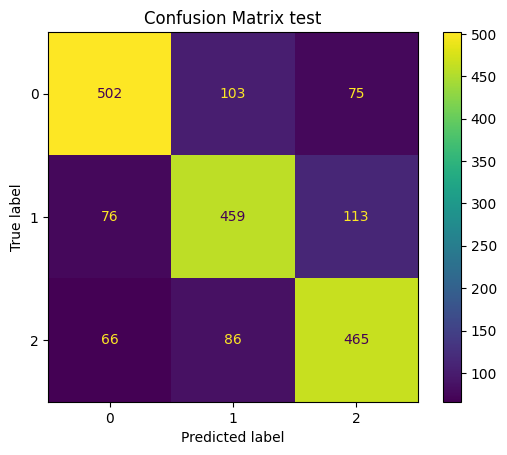

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.8281762003898621     │
│      source_test/f1       │    0.8275449872016907     │
│   source_test/f1_macro    │    0.8232700228691101     │
│   source_test/f1_micro    │    0.8281762003898621     │
│     source_test/loss      │    0.5556901693344116     │
│   target_test/accuracy    │    0.7335450649261475     │
│      target_test/f1       │    0.7337862849235535     │
│   target_test/f1_macro    │    0.7211281061172485     │
│   target_test/f1_micro    │    0.7335450649261475     │
│     target_test/loss      │     0.848854124546051     │
└───────────────────────────┴───────────────────────────┘

Test Results Last Epoch: [{'source_test/loss': 0.5556901693344116, 'source_test/accuracy': 0.8281762003898621, 'source_test/f1': 0.8275449872016907, 'source_test/f1_macro': 0.8232700228691101, 'source_test/f1_micro': 0.8281762003898621, 'target_test/loss': 0.848854124546051, 'target_test/accuracy': 0.7335450649261475, 'target_test/f1': 0.7337862849235535, 'target_test/f1_macro': 0.7211281061172485, 'target_test/f1_micro': 0.7335450649261475}]
Best checkpoint path: checkpoints/lightning_logs/version_12/checkpoints/task-GS-epoch=01-val_loss=0.48.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_12/checkpoints/GS-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_S              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1945, 128, 768)
Labels shape: (1945,)
Flattened features shape: (1945, 98304)


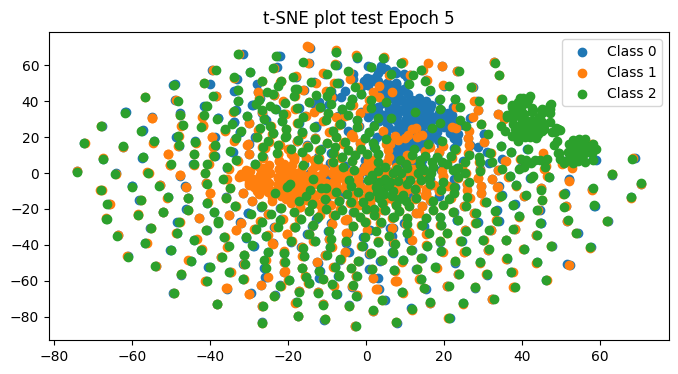

y_true shape: (1945,)
y_pred shape: (1945,)


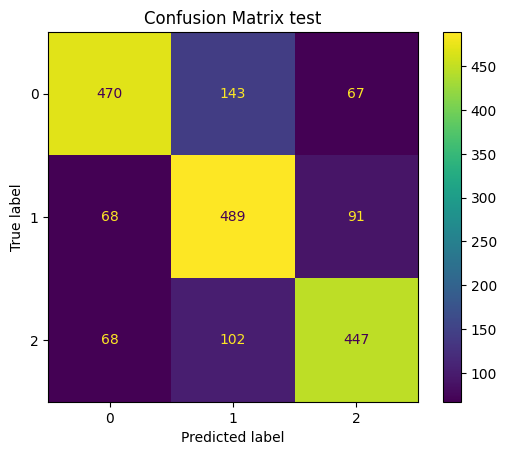

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.8126639127731323     │
│      source_test/f1       │    0.8113084435462952     │
│   source_test/f1_macro    │    0.8068957924842834     │
│   source_test/f1_micro    │    0.8126639127731323     │
│     source_test/loss      │    0.4853793680667877     │
│   target_test/accuracy    │     0.723155677318573     │
│      target_test/f1       │    0.7227738499641418     │
│   target_test/f1_macro    │    0.7116612792015076     │
│   target_test/f1_micro    │     0.723155677318573     │
│     target_test/loss      │    0.7206884622573853     │
└───────────────────────────┴───────────────────────────┘

Test Results on Best Model: [{'source_test/loss': 0.4853793680667877, 'source_test/accuracy': 0.8126639127731323, 'source_test/f1': 0.8113084435462952, 'source_test/f1_macro': 0.8068957924842834, 'source_test/f1_micro': 0.8126639127731323, 'target_test/loss': 0.7206884622573853, 'target_test/accuracy': 0.723155677318573, 'target_test/f1': 0.7227738499641418, 'target_test/f1_macro': 0.7116612792015076, 'target_test/f1_micro': 0.723155677318573}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_S              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1945, 128, 768)
Labels shape: (1945,)
Flattened features shape: (1945, 98304)


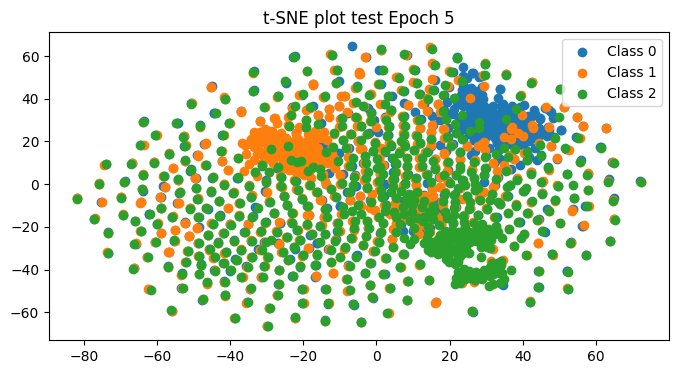

y_true shape: (1945,)
y_pred shape: (1945,)


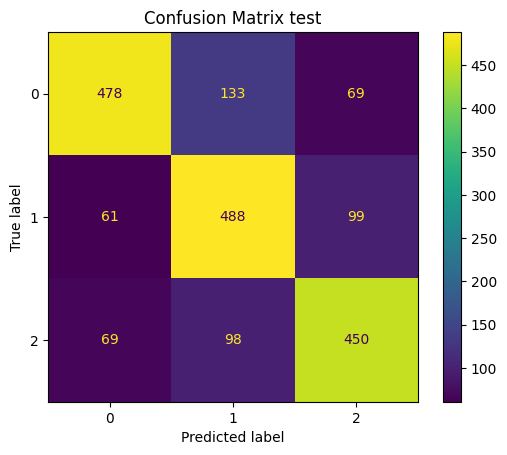

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.8292007446289062     │
│      source_test/f1       │     0.828401505947113     │
│   source_test/f1_macro    │     0.823991596698761     │
│   source_test/f1_micro    │    0.8292007446289062     │
│     source_test/loss      │    0.5031297206878662     │
│   target_test/accuracy    │    0.7279917597770691     │
│      target_test/f1       │    0.7269635796546936     │
│   target_test/f1_macro    │    0.7187973260879517     │
│   target_test/f1_micro    │    0.7279917597770691     │
│     target_test/loss      │    0.7556334137916565     │
└───────────────────────────┴───────────────────────────┘

Seed set to 10


Test Results on saved epoch: [{'source_test/loss': 0.5031297206878662, 'source_test/accuracy': 0.8292007446289062, 'source_test/f1': 0.828401505947113, 'source_test/f1_macro': 0.823991596698761, 'source_test/f1_micro': 0.8292007446289062, 'target_test/loss': 0.7556334137916565, 'target_test/accuracy': 0.7279917597770691, 'target_test/f1': 0.7269635796546936, 'target_test/f1_macro': 0.7187973260879517, 'target_test/f1_micro': 0.7279917597770691}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prinssst: government
print: slate
print: 69575
prinssst: government
print: slate
print: 69575


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_S              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 1.1058225631713867
target_val/accuracy: 0.328125
target_val/f1: 0.4920944571495056
source_val/loss: 1.0828115940093994
source_val/accuracy: 0.453125
source_val/f1: 0.5675129294395447
Features shape: (64, 128, 768)
Labels shape: (64,)
Flattened features shape: (64, 98304)


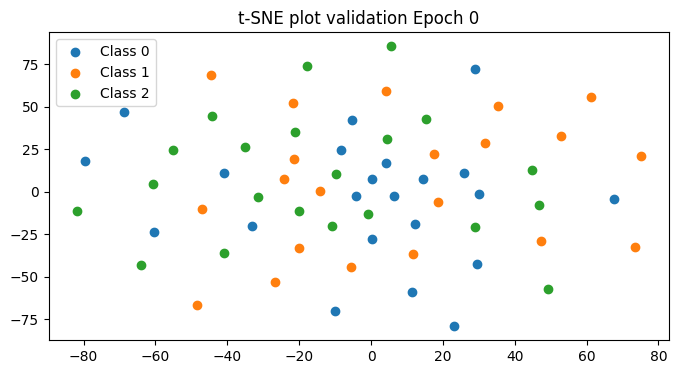

y_true shape: (64,)
y_pred shape: (64,)


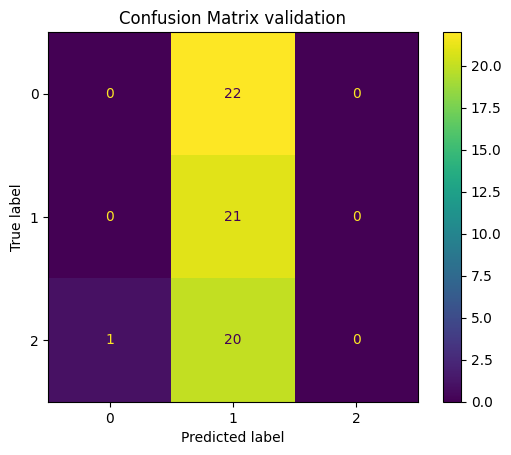

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6770085692405701
target_val/accuracy: 0.7199393510818481
target_val/f1: 0.7195585370063782
source_val/loss: 0.5027586221694946
source_val/accuracy: 0.8018567562103271
source_val/f1: 0.8013530969619751
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


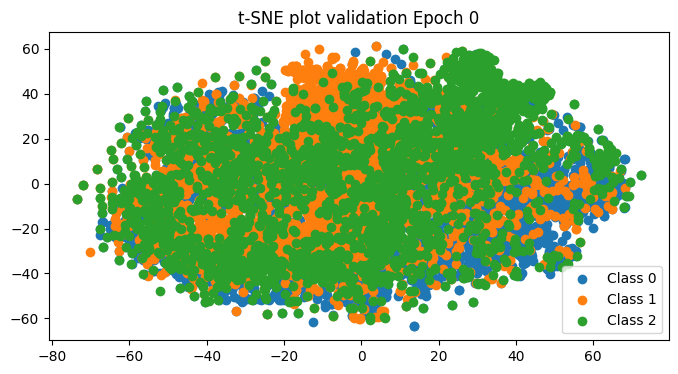

y_true shape: (7731,)
y_pred shape: (7731,)


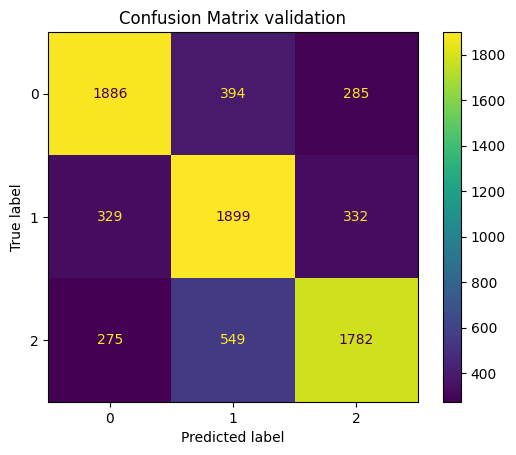

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6913695335388184
target_val/accuracy: 0.7246288657188416
target_val/f1: 0.7242287397384644
source_val/loss: 0.4987598657608032
source_val/accuracy: 0.8125747442245483
source_val/f1: 0.8117544651031494
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


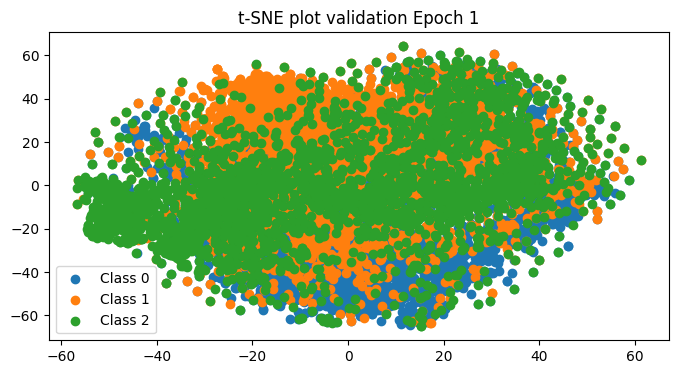

y_true shape: (7731,)
y_pred shape: (7731,)


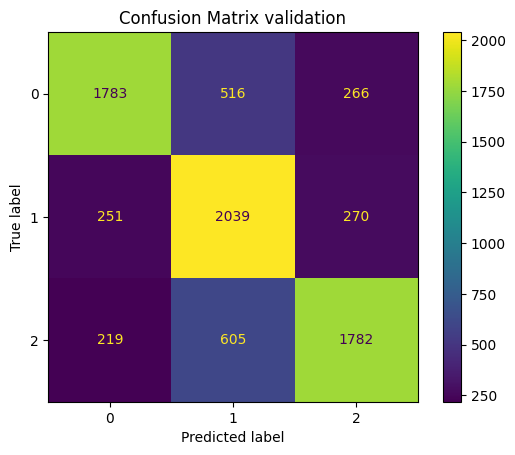

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.7082626223564148
target_val/accuracy: 0.7375896573066711
target_val/f1: 0.7370536923408508
source_val/loss: 0.5051336288452148
source_val/accuracy: 0.8244549036026001
source_val/f1: 0.824069082736969
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


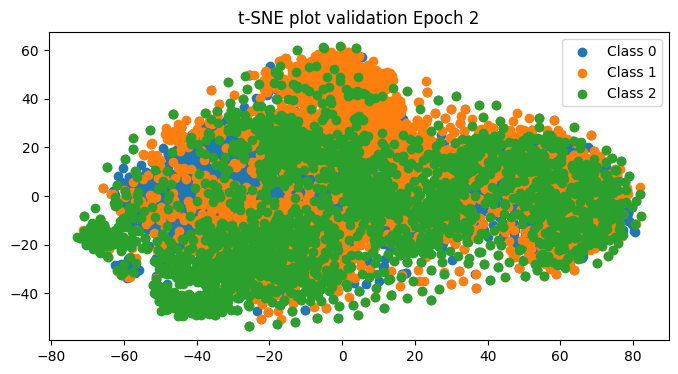

y_true shape: (7731,)
y_pred shape: (7731,)


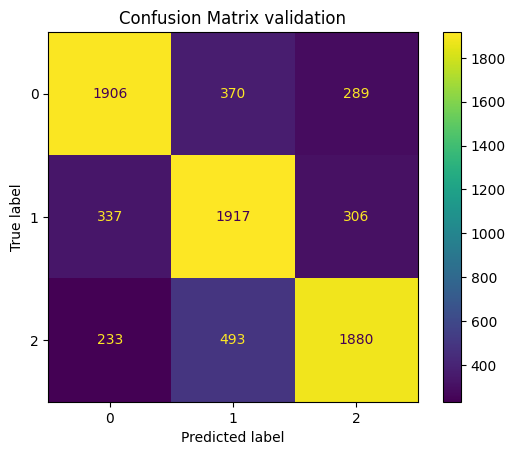

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.7198423743247986
target_val/accuracy: 0.7504621744155884
target_val/f1: 0.7510616779327393
source_val/loss: 0.5123739242553711
source_val/accuracy: 0.8287162780761719
source_val/f1: 0.8288962244987488
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


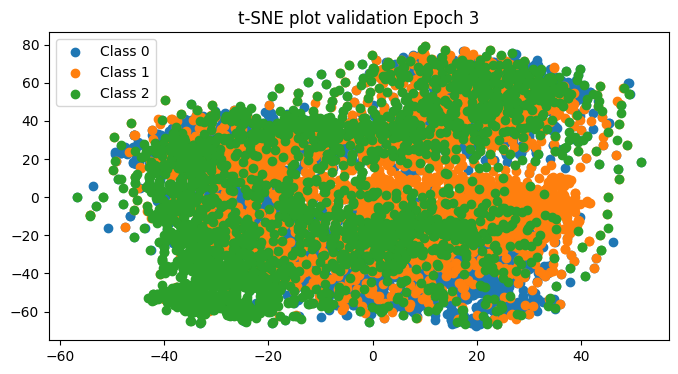

y_true shape: (7731,)
y_pred shape: (7731,)


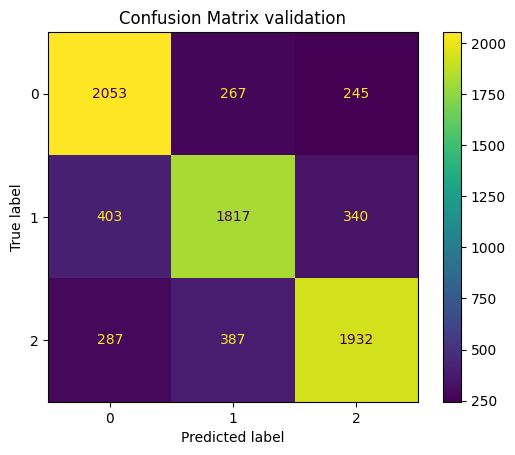

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.7631111741065979
target_val/accuracy: 0.7357410788536072
target_val/f1: 0.7357637286186218
source_val/loss: 0.5392082929611206
source_val/accuracy: 0.8241966366767883
source_val/f1: 0.8242484927177429
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


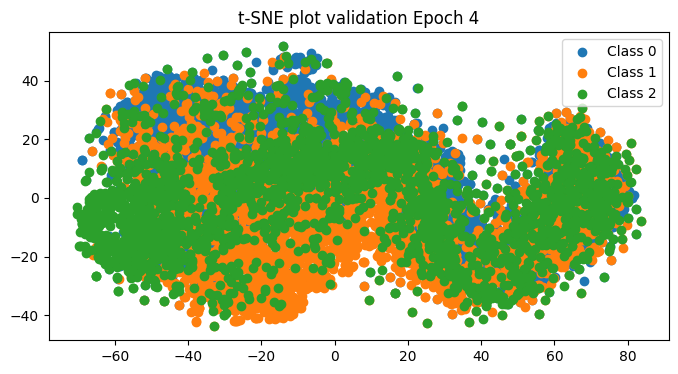

y_true shape: (7731,)
y_pred shape: (7731,)


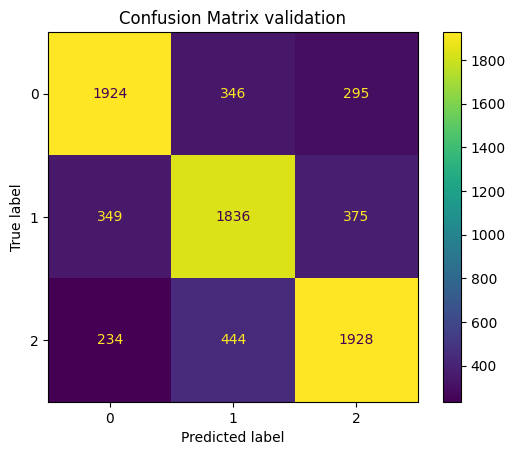

`Trainer.fit` stopped: `max_epochs=5` reached.


Best checkpoint path: checkpoints/lightning_logs/version_13/checkpoints/task-GS-epoch=01-val_loss=0.50.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_13/checkpoints/GS-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


prinssst: government
print: slate
print: 69575


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1945, 128, 768)
Labels shape: (1945,)
Flattened features shape: (1945, 98304)


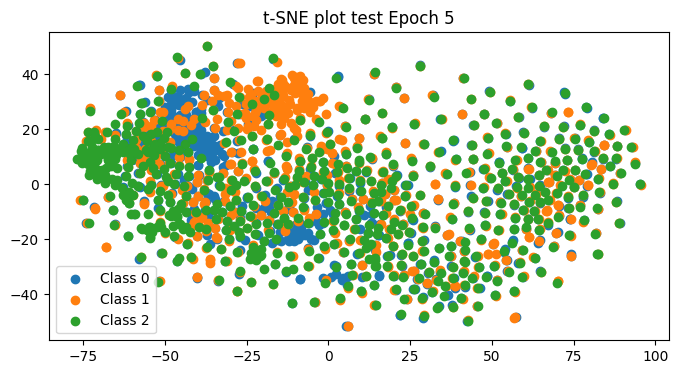

y_true shape: (1945,)
y_pred shape: (1945,)


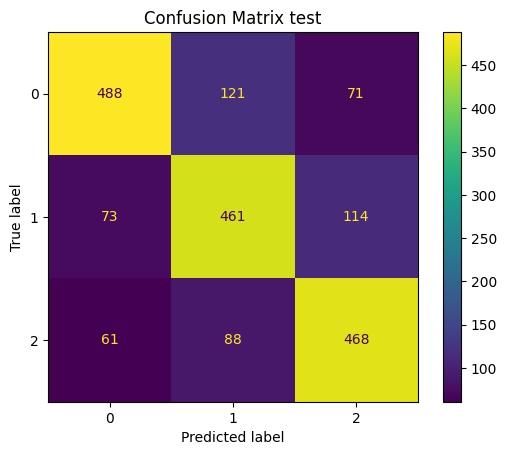

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.8322745561599731     │
│      source_test/f1       │    0.8315985798835754     │
│   source_test/f1_macro    │    0.8277291059494019     │
│   source_test/f1_micro    │    0.8322745561599731     │
│     source_test/loss      │    0.5521684885025024     │
│   target_test/accuracy    │    0.7285040616989136     │
│      target_test/f1       │    0.7285252809524536     │
│   target_test/f1_macro    │    0.7154406309127808     │
│   target_test/f1_micro    │    0.7285040616989136     │
│     target_test/loss      │    0.8167183995246887     │
└───────────────────────────┴───────────────────────────┘

Test Results Last Epoch: [{'source_test/loss': 0.5521684885025024, 'source_test/accuracy': 0.8322745561599731, 'source_test/f1': 0.8315985798835754, 'source_test/f1_macro': 0.8277291059494019, 'source_test/f1_micro': 0.8322745561599731, 'target_test/loss': 0.8167183995246887, 'target_test/accuracy': 0.7285040616989136, 'target_test/f1': 0.7285252809524536, 'target_test/f1_macro': 0.7154406309127808, 'target_test/f1_micro': 0.7285040616989136}]
Best checkpoint path: checkpoints/lightning_logs/version_13/checkpoints/task-GS-epoch=01-val_loss=0.50.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_13/checkpoints/GS-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_S              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1945, 128, 768)
Labels shape: (1945,)
Flattened features shape: (1945, 98304)


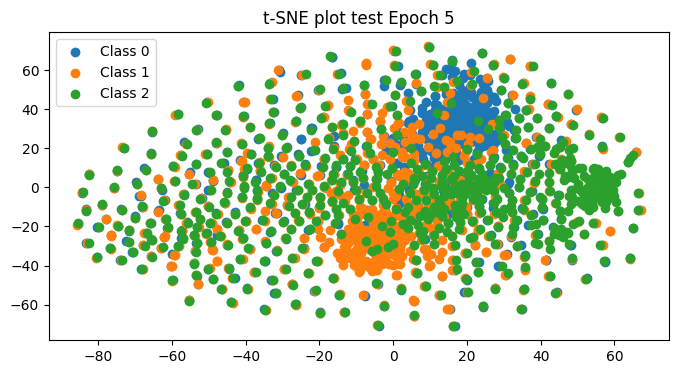

y_true shape: (1945,)
y_pred shape: (1945,)


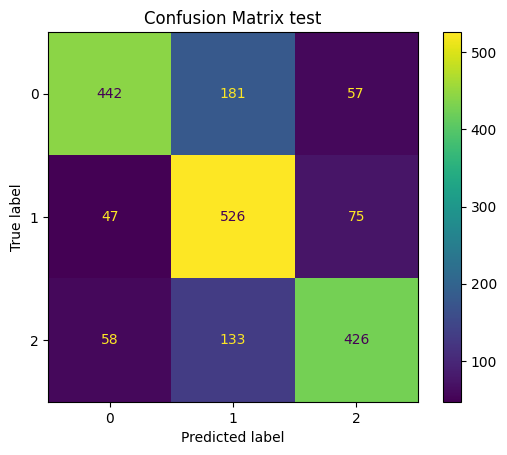

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.8133196234703064     │
│      source_test/f1       │    0.8121839761734009     │
│   source_test/f1_macro    │    0.8093970417976379     │
│   source_test/f1_micro    │    0.8133196234703064     │
│     source_test/loss      │    0.5216415524482727     │
│   target_test/accuracy    │    0.7165778279304504     │
│      target_test/f1       │    0.7170873880386353     │
│   target_test/f1_macro    │    0.7049241065979004     │
│   target_test/f1_micro    │    0.7165778279304504     │
│     target_test/loss      │    0.7324955463409424     │
└───────────────────────────┴───────────────────────────┘

Test Results on Best Model: [{'source_test/loss': 0.5216415524482727, 'source_test/accuracy': 0.8133196234703064, 'source_test/f1': 0.8121839761734009, 'source_test/f1_macro': 0.8093970417976379, 'source_test/f1_micro': 0.8133196234703064, 'target_test/loss': 0.7324955463409424, 'target_test/accuracy': 0.7165778279304504, 'target_test/f1': 0.7170873880386353, 'target_test/f1_macro': 0.7049241065979004, 'target_test/f1_micro': 0.7165778279304504}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_S              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1945, 128, 768)
Labels shape: (1945,)
Flattened features shape: (1945, 98304)


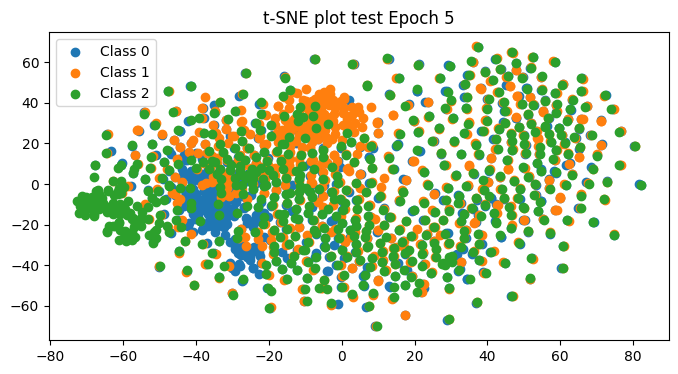

y_true shape: (1945,)
y_pred shape: (1945,)


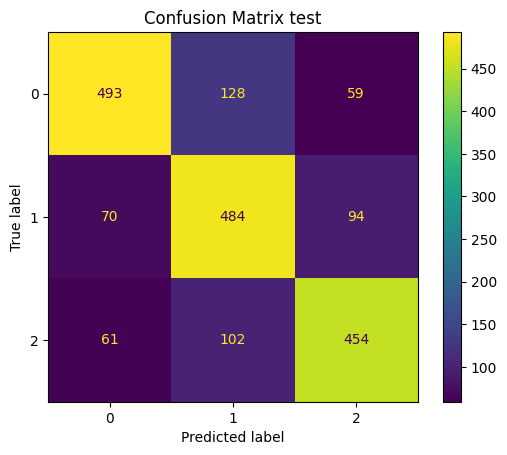

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.8281762003898621     │
│      source_test/f1       │    0.8272092938423157     │
│   source_test/f1_macro    │    0.8235061168670654     │
│   source_test/f1_micro    │    0.8281762003898621     │
│     source_test/loss      │    0.5055961012840271     │
│   target_test/accuracy    │    0.7356762290000916     │
│      target_test/f1       │    0.7350263595581055     │
│   target_test/f1_macro    │    0.7225217819213867     │
│   target_test/f1_micro    │    0.7356762290000916     │
│     target_test/loss      │    0.7411820888519287     │
└───────────────────────────┴───────────────────────────┘

Test Results on saved epoch: [{'source_test/loss': 0.5055961012840271, 'source_test/accuracy': 0.8281762003898621, 'source_test/f1': 0.8272092938423157, 'source_test/f1_macro': 0.8235061168670654, 'source_test/f1_micro': 0.8281762003898621, 'target_test/loss': 0.7411820888519287, 'target_test/accuracy': 0.7356762290000916, 'target_test/f1': 0.7350263595581055, 'target_test/f1_macro': 0.7225217819213867, 'target_test/f1_micro': 0.7356762290000916}]


In [7]:
for seed in seeds:
    #wandb.init(project=project_name, name=f'{domain}_{type}_run_with_seed_{seed}', config={'seed': seed})

    try:
        seed_everything(seed)

        hparams = {
            "source_target": "government_slate",
            "source_domain": "government",
            "target_domain": "slate",
            "domain_adapter_name": "mlm_union_S",
            "task_adapter_name": "task_GS",
            "pretrained_model_name": "bert-base-uncased",
            "padding": "max_length",
            "max_seq_length": 128,
            "bsz": 32,
            "num_classes": 3,
            "learning_rate": 1e-4,
            "reduction_factor": 16,
            "mode": "domain",
            "saved_adapter_dir": "../../saved/adapters",
        }

        save_dir = "checkpoints"
        save_epoch_3 = 3  # Save model at the 3rd epoch
        #save_model_callback_epoch = SaveModelAtEpochCallback(save_dir, save_epoch_3)
        # Add a print statement to confirm the callback initialization
        #print(f"Initialized SaveModelAtEpochCallback with save_dir={save_dir} and save_epoch={save_epoch_3}")
        dm = processed.DataModuleSourceTarget(hparams)
        dm.setup('fit')
        dm.setup("test")

        model = DomainTaskAdapter(hparams)

        checkpoint_callback = ModelCheckpoint(
            filename="task-GS-{epoch:02d}-{val_loss:.2f}",
            save_top_k=1,
            monitor="val_loss",
            mode="min",
        )
        save_model_callback_epoch = ModelCheckpoint(
                # dirpath=checkpoints_path, # <--- specify this on the trainer itself for version control
                filename="GS-{epoch:02d}",
                every_n_epochs=save_epoch_3,
                save_top_k=-1,  # <--- this is important!
            )
       
        #wandb_logger = WandbLogger()
        
    except Exception as e:
        print(f"Error during preprocessing : {e}")   

    try:
        train_loader = dm.train_dataloader()
        val_loader = dm.val_dataloader()
        trainer = Trainer(
            max_epochs=5,
            accelerator="auto",
            default_root_dir="checkpoints",
            # precision=16,
            #logger=wandb_logger,
            callbacks=[checkpoint_callback,save_model_callback_epoch],
            limit_train_batches=1.0,
            limit_val_batches=1.0,
            limit_test_batches=1.0,
            # log_every_n_TESps=10,
        )
      
        trainer.fit(model, train_loader, val_loader)
           # ATESr training, print the paths to verify
        print(f"Best checkpoint path: {checkpoint_callback.best_model_path}")
        print(f"Saved epoch checkpoint path: {save_model_callback_epoch.best_model_path}")
    except Exception as e:
        print(f"Error during training : {e}")

    try:
        
        dm.setup("test")
        test_loader = dm.test_dataloader()
        test_results_last = trainer.test(model, test_loader)
        print("Test Results Last Epoch:", test_results_last)

        # Collect results for last epoch model
        for key, value in test_results_last[0].items():
            results["last_epoch"][key].append(value)

        # Paths to the saved checkpoints
        best_checkpoint_path = checkpoint_callback.best_model_path
        saved_epoch_checkpoint_path = save_model_callback_epoch.best_model_path
        # Print the paths to verify
        print(f"Best checkpoint path: {best_checkpoint_path}")
        print(f"Saved epoch checkpoint path: {saved_epoch_checkpoint_path}")
        
        best_model = DomainTaskAdapter.load_from_checkpoint(best_checkpoint_path)
        test_results_best = trainer.test(best_model, test_loader)
        print("Test Results on Best Model:", test_results_best)
        # Collect results for best model
        for key, value in test_results_best[0].items():
            results["best_model"][key].append(value)

        saved_epoch_model = DomainTaskAdapter.load_from_checkpoint(saved_epoch_checkpoint_path)
        test_results_saved_epoch = trainer.test(saved_epoch_model, test_loader)
        print("Test Results on saved epoch:", test_results_saved_epoch)
        # Collect results for 3rd epoch model
        for key, value in test_results_saved_epoch[0].items():
            results["epoch_saved"][key].append(value)
        

    except Exception as e:
        print(f"Error during testing: {e}")

    # Finish the wandb run
    #wandb.finish()

Seed set to 100
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prinssst: government
print: slate
print: 69575
prinssst: government
print: slate
print: 69575


wandb: Network error (ReadTimeout), entering retry loop.


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configu

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_S              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | BertAdapterModel   | 118 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
3 | f1        | MulticlassF1Score  | 0     
4 | f1_macro  | MulticlassF1Score  | 0     
5 | f1_micro  | MulticlassF1Score  | 0     
6 | softmax   | Softmax            | 0     
-------------------------------------------------
8.9 M     Trainable params
109 M     Non-trainable params
118 M     Total params
473.522   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 1.0995721817016602
target_val/accuracy: 0.34375
target_val/f1: 0.39176037907600403
source_val/loss: 1.093321681022644
source_val/accuracy: 0.4375
source_val/f1: 0.4868595600128174
Features shape: (64, 128, 768)
Labels shape: (64,)
Flattened features shape: (64, 98304)


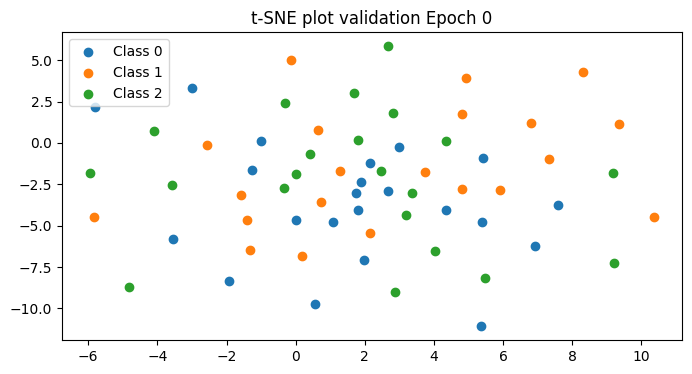

y_true shape: (64,)
y_pred shape: (64,)


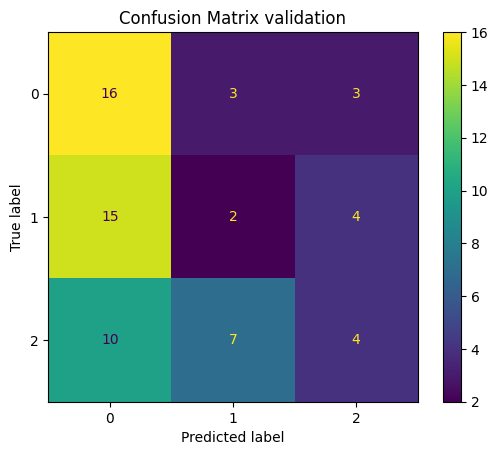

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6965248584747314
target_val/accuracy: 0.7050008177757263
target_val/f1: 0.7051414847373962
source_val/loss: 0.5131906867027283
source_val/accuracy: 0.7978128790855408
source_val/f1: 0.7967643141746521
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


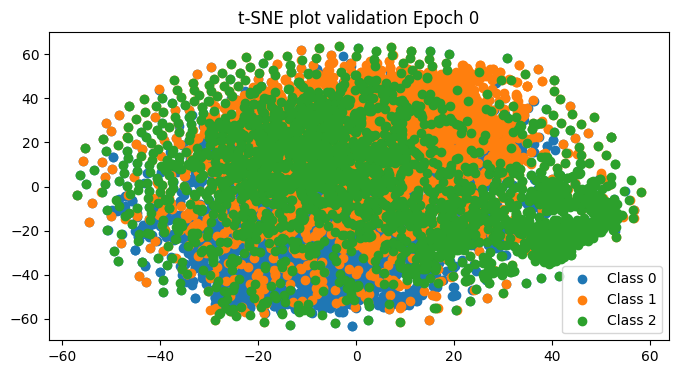

y_true shape: (7731,)
y_pred shape: (7731,)


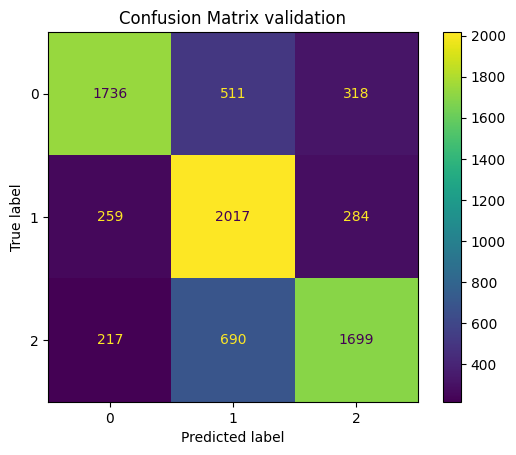

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6750994920730591
target_val/accuracy: 0.7305757999420166
target_val/f1: 0.7302014827728271
source_val/loss: 0.4874148666858673
source_val/accuracy: 0.8195886015892029
source_val/f1: 0.8189010620117188
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


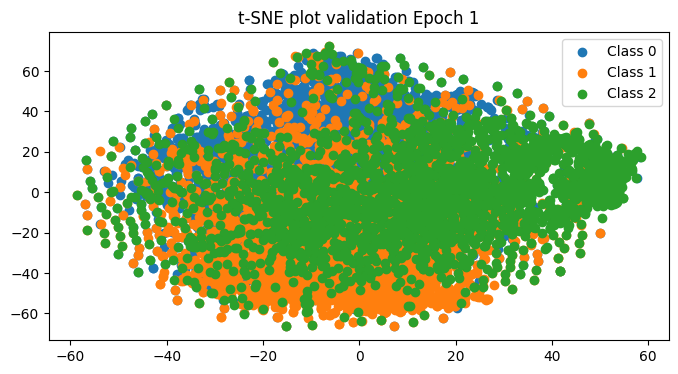

y_true shape: (7731,)
y_pred shape: (7731,)


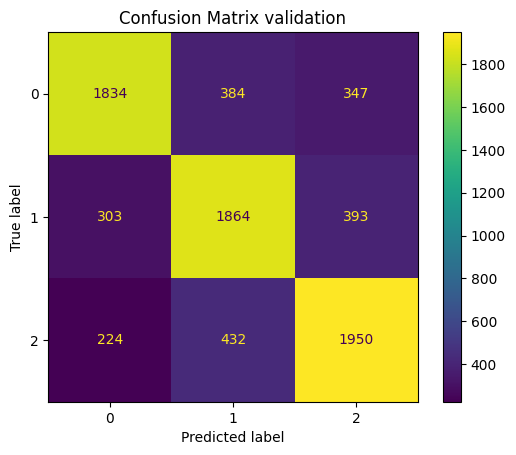

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6812277436256409
target_val/accuracy: 0.7415519952774048
target_val/f1: 0.7414044141769409
source_val/loss: 0.4829065501689911
source_val/accuracy: 0.8243665099143982
source_val/f1: 0.8241029381752014
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


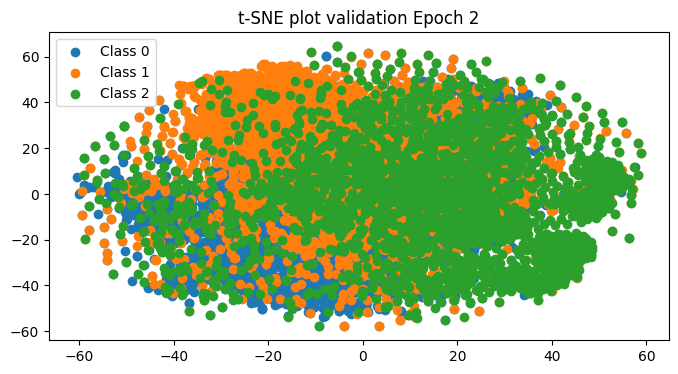

y_true shape: (7731,)
y_pred shape: (7731,)


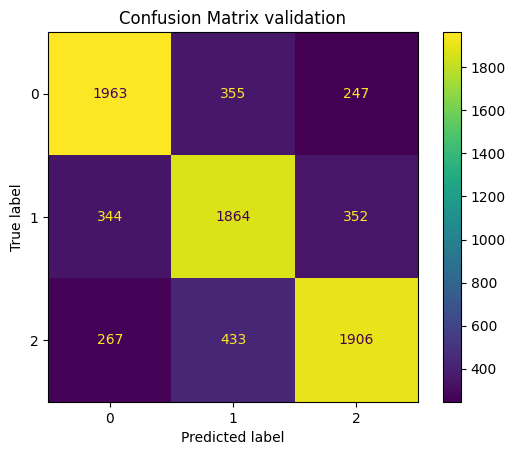

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.7408413887023926
target_val/accuracy: 0.7405596971511841
target_val/f1: 0.7404419183731079
source_val/loss: 0.5267279148101807
source_val/accuracy: 0.8181205987930298
source_val/f1: 0.817895233631134
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


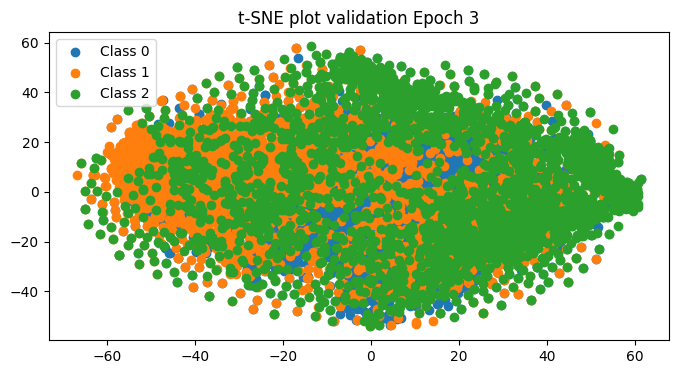

y_true shape: (7731,)
y_pred shape: (7731,)


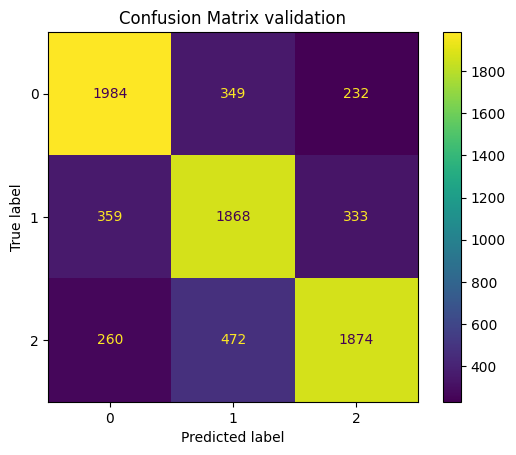

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.8033061027526855
target_val/accuracy: 0.7380246520042419
target_val/f1: 0.7392334342002869
source_val/loss: 0.5580459237098694
source_val/accuracy: 0.8225179314613342
source_val/f1: 0.8230553269386292
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


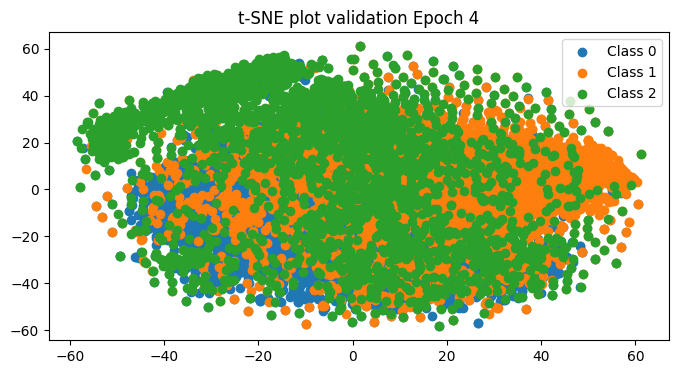

y_true shape: (7731,)
y_pred shape: (7731,)


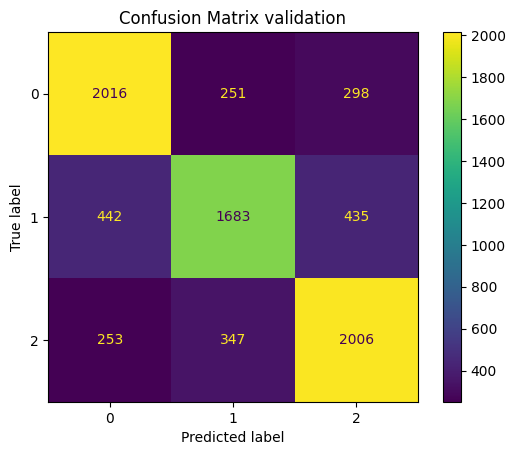

`Trainer.fit` stopped: `max_epochs=5` reached.


Best checkpoint path: checkpoints/lightning_logs/version_4/checkpoints/task-GS-epoch=02-val_loss=0.48.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_4/checkpoints/GS-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


prinssst: government
print: slate
print: 69575


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1945, 128, 768)
Labels shape: (1945,)
Flattened features shape: (1945, 98304)


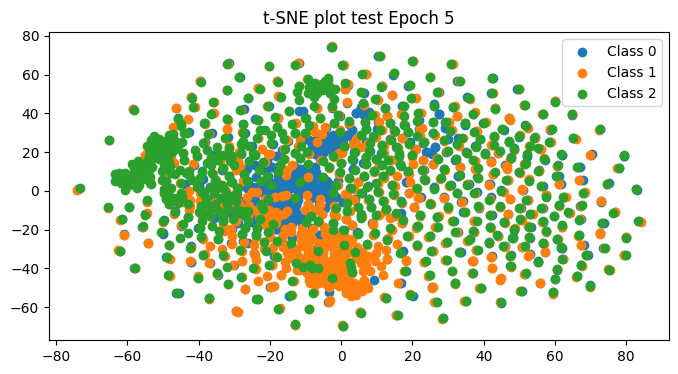

y_true shape: (1945,)
y_pred shape: (1945,)


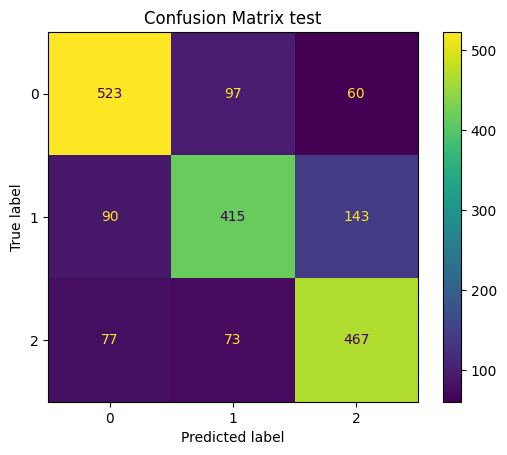

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.8334425687789917     │
│      source_test/f1       │     0.833318829536438     │
│   source_test/f1_macro    │    0.8281533122062683     │
│   source_test/f1_micro    │    0.8334425687789917     │
│     source_test/loss      │    0.5197023749351501     │
│   target_test/accuracy    │    0.7223565578460693     │
│      target_test/f1       │    0.7226524353027344     │
│   target_test/f1_macro    │     0.708101749420166     │
│   target_test/f1_micro    │    0.7223565578460693     │
│     target_test/loss      │    0.8530176281929016     │
└───────────────────────────┴───────────────────────────┘

Test Results Last Epoch: [{'source_test/loss': 0.5197023749351501, 'source_test/accuracy': 0.8334425687789917, 'source_test/f1': 0.833318829536438, 'source_test/f1_macro': 0.8281533122062683, 'source_test/f1_micro': 0.8334425687789917, 'target_test/loss': 0.8530176281929016, 'target_test/accuracy': 0.7223565578460693, 'target_test/f1': 0.7226524353027344, 'target_test/f1_macro': 0.708101749420166, 'target_test/f1_micro': 0.7223565578460693}]
Best checkpoint path: checkpoints/lightning_logs/version_4/checkpoints/task-GS-epoch=02-val_loss=0.48.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_4/checkpoints/GS-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_S              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1945, 128, 768)
Labels shape: (1945,)
Flattened features shape: (1945, 98304)


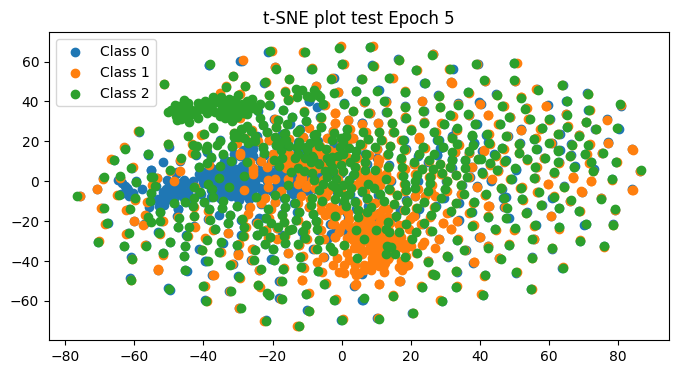

y_true shape: (1945,)
y_pred shape: (1945,)


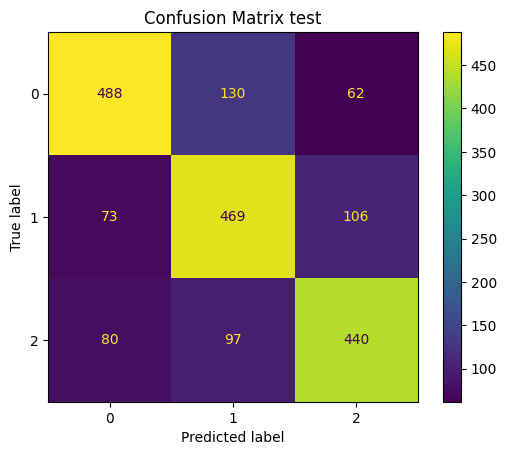

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.8281762003898621     │
│      source_test/f1       │    0.8270611763000488     │
│   source_test/f1_macro    │    0.8238152265548706     │
│   source_test/f1_micro    │    0.8281762003898621     │
│     source_test/loss      │    0.49313732981681824    │
│   target_test/accuracy    │    0.7184016108512878     │
│      target_test/f1       │    0.7171213626861572     │
│   target_test/f1_macro    │    0.7073184847831726     │
│   target_test/f1_micro    │    0.7184016108512878     │
│     target_test/loss      │     0.737483024597168     │
└───────────────────────────┴───────────────────────────┘

Test Results on Best Model: [{'source_test/loss': 0.49313732981681824, 'source_test/accuracy': 0.8281762003898621, 'source_test/f1': 0.8270611763000488, 'source_test/f1_macro': 0.8238152265548706, 'source_test/f1_micro': 0.8281762003898621, 'target_test/loss': 0.737483024597168, 'target_test/accuracy': 0.7184016108512878, 'target_test/f1': 0.7171213626861572, 'target_test/f1_macro': 0.7073184847831726, 'target_test/f1_micro': 0.7184016108512878}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_S              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1945, 128, 768)
Labels shape: (1945,)
Flattened features shape: (1945, 98304)


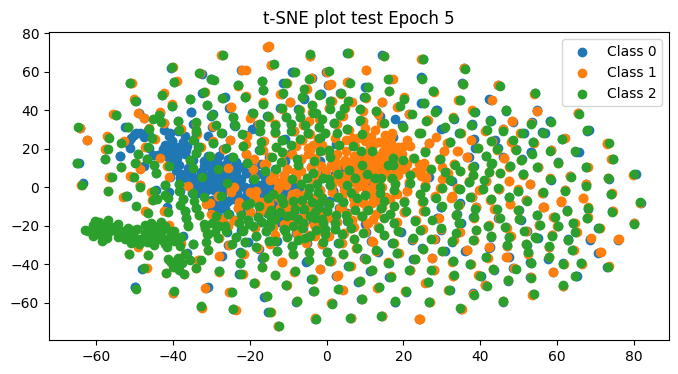

y_true shape: (1945,)
y_pred shape: (1945,)


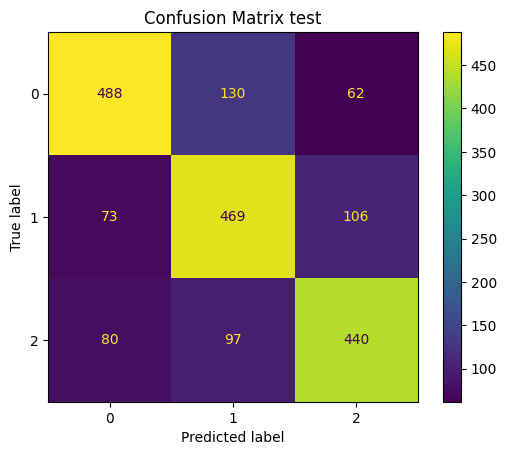

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.8281762003898621     │
│      source_test/f1       │    0.8270611763000488     │
│   source_test/f1_macro    │    0.8238152265548706     │
│   source_test/f1_micro    │    0.8281762003898621     │
│     source_test/loss      │    0.49313732981681824    │
│   target_test/accuracy    │    0.7184016108512878     │
│      target_test/f1       │    0.7171213626861572     │
│   target_test/f1_macro    │    0.7073184847831726     │
│   target_test/f1_micro    │    0.7184016108512878     │
│     target_test/loss      │     0.737483024597168     │
└───────────────────────────┴───────────────────────────┘

Test Results on saved epoch: [{'source_test/loss': 0.49313732981681824, 'source_test/accuracy': 0.8281762003898621, 'source_test/f1': 0.8270611763000488, 'source_test/f1_macro': 0.8238152265548706, 'source_test/f1_micro': 0.8281762003898621, 'target_test/loss': 0.737483024597168, 'target_test/accuracy': 0.7184016108512878, 'target_test/f1': 0.7171213626861572, 'target_test/f1_macro': 0.7073184847831726, 'target_test/f1_micro': 0.7184016108512878}]


In [7]:
for seed in seeds:
    #wandb.init(project=project_name, name=f'{domain}_{type}_run_with_seed_{seed}', config={'seed': seed})

    try:
        seed_everything(seed)

        hparams = {
            "source_target": "government_slate",
            "source_domain": "government",
            "target_domain": "slate",
            "domain_adapter_name": "mlm_union_S",
            "task_adapter_name": "task_GS",
            "pretrained_model_name": "bert-base-uncased",
            "padding": "max_length",
            "max_seq_length": 128,
            "bsz": 32,
            "num_classes": 3,
            "learning_rate": 1e-4,
            "reduction_factor": 16,
            "mode": "domain",
            "saved_adapter_dir": "../../saved/adapters",
        }

        save_dir = "checkpoints"
        save_epoch_3 = 3  # Save model at the 3rd epoch
        #save_model_callback_epoch = SaveModelAtEpochCallback(save_dir, save_epoch_3)
        # Add a print statement to confirm the callback initialization
        #print(f"Initialized SaveModelAtEpochCallback with save_dir={save_dir} and save_epoch={save_epoch_3}")
        dm = processed.DataModuleSourceTarget(hparams)
        dm.setup('fit')
        dm.setup("test")

        model = DomainTaskAdapter(hparams)

        checkpoint_callback = ModelCheckpoint(
            filename="task-GS-{epoch:02d}-{val_loss:.2f}",
            save_top_k=1,
            monitor="val_loss",
            mode="min",
        )
        save_model_callback_epoch = ModelCheckpoint(
                # dirpath=checkpoints_path, # <--- specify this on the trainer itself for version control
                filename="GS-{epoch:02d}",
                every_n_epochs=save_epoch_3,
                save_top_k=-1,  # <--- this is important!
            )
       
        #wandb_logger = WandbLogger()
        
    except Exception as e:
        print(f"Error during preprocessing : {e}")   

    try:
        train_loader = dm.train_dataloader()
        val_loader = dm.val_dataloader()
        trainer = Trainer(
            max_epochs=5,
            accelerator="auto",
            default_root_dir="checkpoints",
            # precision=16,
            #logger=wandb_logger,
            callbacks=[checkpoint_callback,save_model_callback_epoch],
            limit_train_batches=1.0,
            limit_val_batches=1.0,
            limit_test_batches=1.0,
            # log_every_n_TESps=10,
        )
      
        trainer.fit(model, train_loader, val_loader)
           # ATESr training, print the paths to verify
        print(f"Best checkpoint path: {checkpoint_callback.best_model_path}")
        print(f"Saved epoch checkpoint path: {save_model_callback_epoch.best_model_path}")
    except Exception as e:
        print(f"Error during training : {e}")

    try:
        
        dm.setup("test")
        test_loader = dm.test_dataloader()
        test_results_last = trainer.test(model, test_loader)
        print("Test Results Last Epoch:", test_results_last)

        # Collect results for last epoch model
        for key, value in test_results_last[0].items():
            results["last_epoch"][key].append(value)

        # Paths to the saved checkpoints
        best_checkpoint_path = checkpoint_callback.best_model_path
        saved_epoch_checkpoint_path = save_model_callback_epoch.best_model_path
        # Print the paths to verify
        print(f"Best checkpoint path: {best_checkpoint_path}")
        print(f"Saved epoch checkpoint path: {saved_epoch_checkpoint_path}")
        
        best_model = DomainTaskAdapter.load_from_checkpoint(best_checkpoint_path)
        test_results_best = trainer.test(best_model, test_loader)
        print("Test Results on Best Model:", test_results_best)
        # Collect results for best model
        for key, value in test_results_best[0].items():
            results["best_model"][key].append(value)

        saved_epoch_model = DomainTaskAdapter.load_from_checkpoint(saved_epoch_checkpoint_path)
        test_results_saved_epoch = trainer.test(saved_epoch_model, test_loader)
        print("Test Results on saved epoch:", test_results_saved_epoch)
        # Collect results for 3rd epoch model
        for key, value in test_results_saved_epoch[0].items():
            results["epoch_saved"][key].append(value)
        

    except Exception as e:
        print(f"Error during testing: {e}")

    # Finish the wandb run
    #wandb.finish()

In [8]:
results.items()

dict_items([('last_epoch', {'source_test/loss': [0.5197023749351501], 'source_test/accuracy': [0.8334425687789917], 'source_test/f1': [0.833318829536438], 'source_test/f1_macro': [0.8281533122062683], 'source_test/f1_micro': [0.8334425687789917], 'target_test/loss': [0.8530176281929016], 'target_test/accuracy': [0.7223565578460693], 'target_test/f1': [0.7226524353027344], 'target_test/f1_macro': [0.708101749420166], 'target_test/f1_micro': [0.7223565578460693]}), ('best_model', {'source_test/loss': [0.49313732981681824], 'source_test/accuracy': [0.8281762003898621], 'source_test/f1': [0.8270611763000488], 'source_test/f1_macro': [0.8238152265548706], 'source_test/f1_micro': [0.8281762003898621], 'target_test/loss': [0.737483024597168], 'target_test/accuracy': [0.7184016108512878], 'target_test/f1': [0.7171213626861572], 'target_test/f1_macro': [0.7073184847831726], 'target_test/f1_micro': [0.7184016108512878]}), ('epoch_saved', {'source_test/loss': [0.49313732981681824], 'source_test/a

| Scenario   | Metric                   | Mean     | Std      |
|------------|--------------------------|----------|----------|
| Saved Epoch| Source Test Accuracy     | 0.82852  | 0.00046  |
|            | Source Test F1           | 0.82756  | 0.00056  |
|            | Source Test F1 Macro     | 0.82377  | 0.00020  |
|            | Source Test F1 Micro     | 0.82852  | 0.00046  |
|            | Target Test Accuracy     | 0.72736  | 0.00709  |
|            | Target Test F1           | 0.72637  | 0.00756  |
|            | Target Test F1 Macro     | 0.71688  | 0.00738  |
|            | Target Test F1 Micro     | 0.72736  | 0.00709  |
| Best Model | Source Test Accuracy     | 0.81803  | 0.00849  |
|            | Source Test F1           | 0.81686  | 0.00835  |
|            | Source Test F1 Macro     | 0.81336  | 0.00817  |
|            | Source Test F1 Micro     | 0.81803  | 0.00849  |
|            | Target Test Accuracy     | 0.71938  | 0.00304  |
|            | Target Test F1           | 0.71866  | 0.00300  |
|            | Target Test F1 Macro     | 0.70777  | 0.00304  |
|            | Target Test F1 Micro     | 0.71938  | 0.00304  |
| Last Epoch | Source Test Accuracy     | 0.83197  | 0.00257  |
|            | Source Test F1           | 0.83082  | 0.00256  |
|            | Source Test F1 Macro     | 0.82638  | 0.00220  |
|            | Source Test F1 Micro     | 0.83197  | 0.00257  |
|            | Target Test Accuracy     | 0.72880  | 0.00422  |
|            | Target Test F1           | 0.72832  | 0.00418  |
|            | Target Test F1 Macro     | 0.71556  | 0.00476  |
|            | Target Test F1 Micro     | 0.72880  | 0.00422  |


In [ ]:
# Calculate mean and standard deviation for each scenario
mean_results = {scenario: {key: np.mean(values) for key, values in metrics.items()} for scenario, metrics in results.items()}
std_results = {scenario: {key: np.std(values) for key, values in metrics.items()} for scenario, metrics in results.items()}

# Log mean and standard deviation results to wandb
wandb.init(project=project_name, name=f'{domain}_mean_results')
for scenario in mean_results:
    for key, value in mean_results[scenario].items():
        wandb.log({f"{scenario}/{key}": value})
        wandb.log({f"{scenario}/{key}_std": std_results[scenario][key]})
wandb.finish()

print("Mean Results:", mean_results)
print("Standard Deviation Results:", std_results)

# # Save the best model's adapter
# if model:
#     adapter_save_path = f"../../saved/adapter_after_run/{hparams['task_adapter_name']}"
#     model.save_adapter(adapter_save_path, hparams['task_adapter_name'])
#     print(f"Adapter saved to {adapter_save_path}")
# else:
#     print("No best model to save.")

In [ ]:
print('dones')

dones


In [ ]:
best_val_loss

inf